In [5]:
import pandas as pd
import numpy as np
import math as mt
from numpy import log
import matplotlib.pyplot as plt
import pyEX as p
token_personal = 'pk_2441e5d6f60845b5a78d6a3cb4be66cb'


# Functions

In [6]:
def make_ret(df, long: bool=True) -> pd.Series:
    """Generates returns.

    Args:
        df (Pandas Dataframe or Series): A series or dataframe of daily close prices.
        long (bool, optional): True indicates long-only, False is for short-only. Defaults to True.
        
    Returns:
        pd.Series: cumulative daily returns, from logged daily close prices.
    """    
    
    if long:
        sign = 1
    else:
        sign = -1

    ret = (
        sign*log(df)
        .groupby(level=1)
        .diff()
        .groupby(level=0)
        .mean()
        .cumsum()
    )
    return ret

In [7]:
def sharpe_ratio(ret, risk_free= 0.0163 ):
    ''' risk_free= 0.0163 #10 Year Treasury Rate
    ret = return of portfolio
    '''
    ret = ret.dropna()
    sharp_ratio = (ret.mean() - risk_free) / ret.std()
    return sharp_ratio

In [8]:
def info_ratio(ret, benchmark):
    ''' i face some problmes in dealing with the two dataframe
    '''
    ret = ret.dropna()
    benchmark = benchmark.dropna()
    ret = ret.values
    benchmark = benchmark.values
    diff = ret - benchmark
    info_ratio = np.mean(diff) / np.std(diff)
    return info_ratio

In [9]:
def sortino_ratio(ret, risk_free):
    ''' risk_free= 0.0163 #10 Year Treasury Rate
    ret = return of portfolio
    '''
    ret = ret.dropna()
    neg_ret = ret[ret<0]
    sortino_ratio = (ret.mean() - risk_free)/neg_ret.std()
    return sortino_ratio

In [59]:
def ret_fra(df):
    df =df.dropna()
    data_return = (df-df.shift(1))/df.shift(1)
    return data_return

# Analisys

In [10]:
c = p.Client(api_token=token_personal)

In [11]:
comapny_list = pd.read_csv('constituents_csv.csv')
stocks = comapny_list['Symbol'].tolist()
comapny_list.head()

c = p.Client(api_token=token_personal)

In [12]:
health = comapny_list[comapny_list['Sector']=='Health Care']
industrial = comapny_list[comapny_list['Sector']=='Industrials']
Consumer_dis = comapny_list[comapny_list['Sector']=='Consumer Discretionary']
total = [Consumer_dis, industrial]
total =pd.concat(total)
total = [total, health]
total =pd.concat(total)


In [ ]:
zio = pd.DataFrame()

for inde,row in total.iterrows():
    r = c.chartDF(symbol= row['Symbol'] , filter='date, symbol, open, high, low, close',timeframe='1m')
    r['Sector'] = row['Sector']
    zio = [zio, r]
    zio = pd.concat(zio)   


In [ ]:
#zio.to_csv('raw_data.csv', index=True)

In [13]:
zio = pd.read_csv('raw_data.csv')

In [15]:
final  = zio.reset_index().set_index(['date','symbol', 'Sector'])

In [16]:
Industrial = final[final.index.isin(['Industrials'], level=2)].close
Health_Care =  final[final.index.isin(['Health Care'], level=2)].close
Consumer_Discretionary =  final[final.index.isin(['Consumer Discretionary'], level=2)].close

In [17]:
Long = make_ret(Industrial, True)

Long_Short = make_ret(Health_Care, True) + make_ret(Consumer_Discretionary, False)

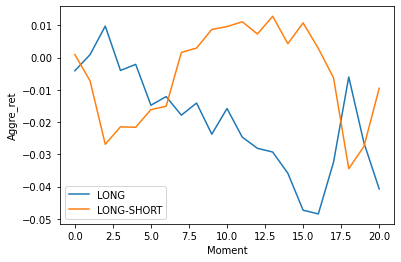

In [18]:
#fig, ax = plt.subplots()
numbers = list((range(0,len(Long))))
plt.xlabel('Moment')
plt.ylabel('Aggre_ret')
plt.plot(numbers, Long.values, label="LONG")
plt.plot(numbers, Long_Short.values, label="LONG-SHORT")
plt.legend()
plt.show()

RETURNS

In [61]:
Long_ret = ret_fra(Long)

In [66]:
Long_Short_ret= ret_fra(Long_Short)

# **INDICATORS FOR LONG**

Sharpe Ratio

In [62]:
risk_free= 0.0163 #10 Year Treasury Rate

In [63]:
sharpe_ratio(Long_ret, risk_free)

0.316885858098235

Sortino Ratio

In [64]:
sortino_ratio(Long_ret, risk_free)

1.8085640803402983

Information Ration with SP500 as index

In [23]:
sp_500 = c.chartDF(symbol= 'SPY' , filter='date, symbol,close',timeframe='1m')

In [24]:
benchmark  = sp_500.reset_index().set_index(['date','symbol'])
ret_benchmark = make_ret(benchmark)

In [65]:
info_ratio(Long_ret, ret_benchmark)

0.3300357554655409

# **INDICATORS FOR LONG + SHORT**

Sharpe Ratio

In [67]:
sharpe_ratio(Long_Short_ret,risk_free)

-0.07714216083785763

Sortino Ratio

In [68]:
sortino_ratio(Long_Short_ret, risk_free)

-0.0768830302518948

Information Ration with SP500 as index

In [28]:
sp_500 = c.chartDF(symbol= 'SPY' , filter='date, symbol,close',timeframe='1m')
benchmark  = sp_500.reset_index().set_index(['date','symbol'])
ret_benchmark = make_ret(benchmark)

In [69]:
info_ratio(Long_Short_ret, ret_benchmark)

-0.07392461073293892